## Prepare imports

In [1]:
import torch
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from models.ectencoder_mnist import BaseModel as EctEncoder
from datasets.mnist import MnistDataModule, MnistDataModuleConfig
from layers.ect import EctLayer, EctConfig
from directions import generate_2d_directions

DEVICE = "cuda:0"
config = OmegaConf.load("./configs/config_encoder_mnist.yaml")

## Load Models and Data

In [2]:
layer = EctLayer(
    EctConfig(
        num_thetas=config.layer.ect_size,
        bump_steps=config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_2d_directions(config.layer.ect_size, DEVICE),
)

dm = MnistDataModule(MnistDataModuleConfig(root="./data/mnistpointcloud"))

# Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/{config.model.save_name}",
    layer=layer,
    ect_size=config.layer.ect_size,
    hidden_size=config.model.hidden_size,
    num_pts=config.model.num_pts,
    num_dims=config.model.num_dims,
    learning_rate=config.model.learning_rate,
).to(DEVICE)


C:\Users\ernst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


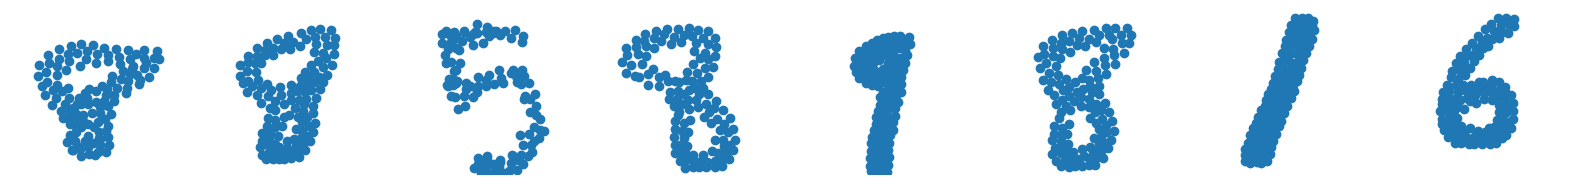

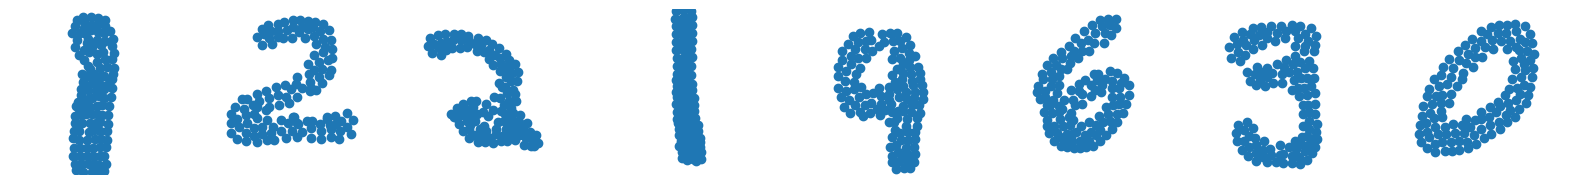

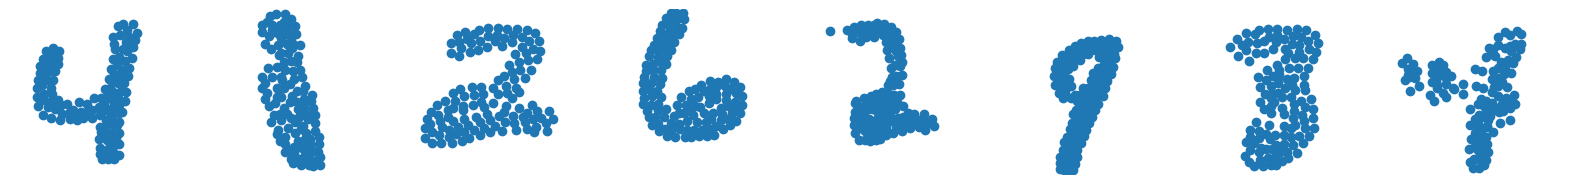

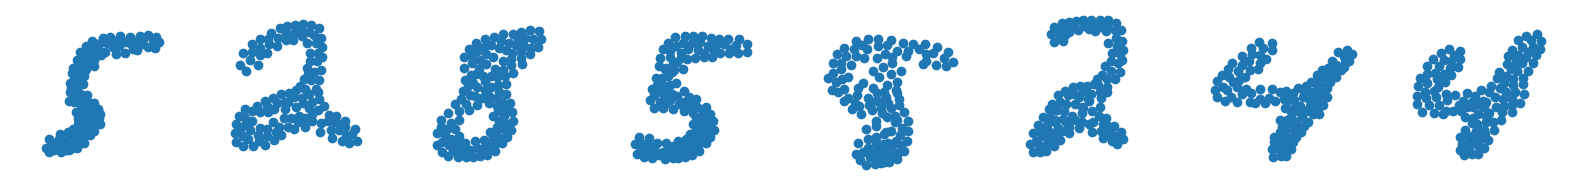

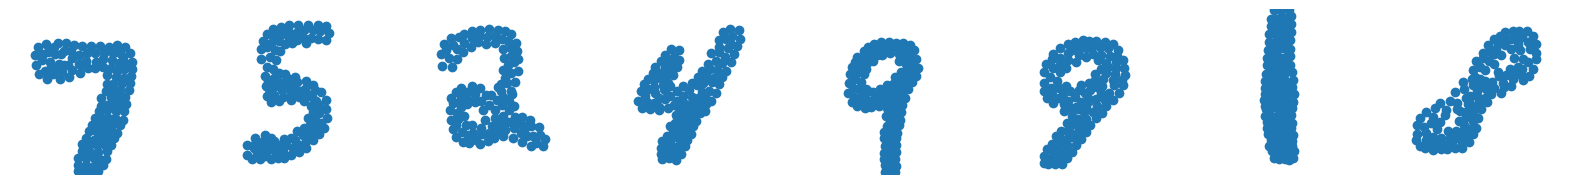

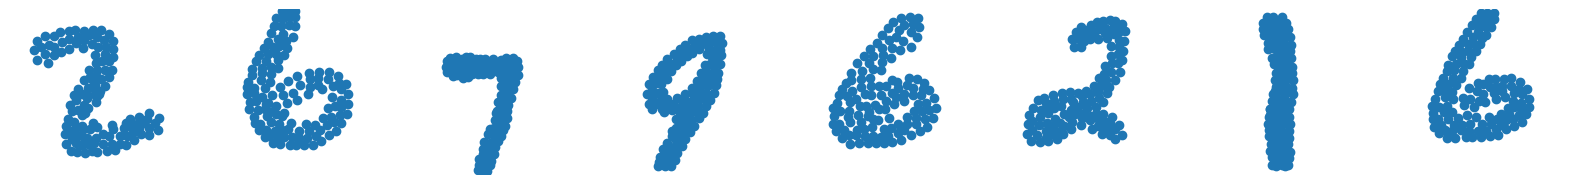

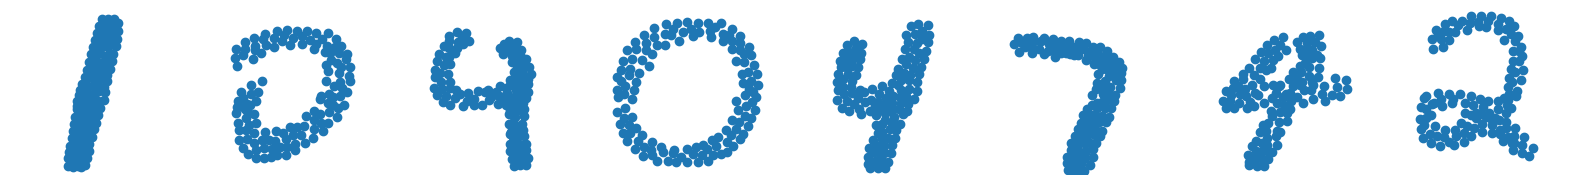

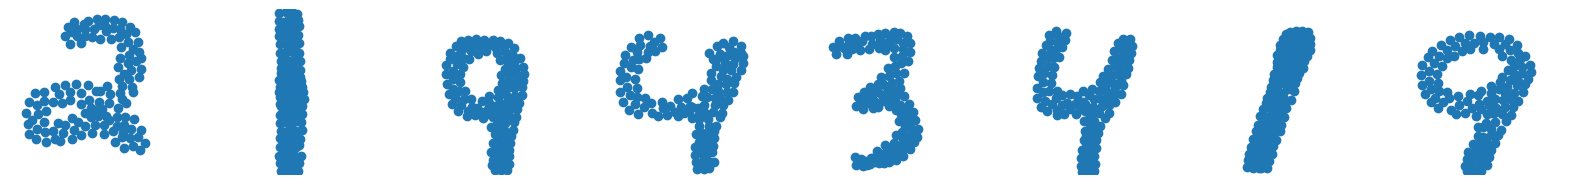

In [3]:
data_loader = dm.val_dataloader()
for batch_idx, features in enumerate(data_loader):
    break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)




# Pass reconstruction through the point cloud decoder


def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

with torch.no_grad():
    recon_batch = ect_encoder_litmodel.model.forward(ect)


n_images = 8

for idx in range(0,64,8):
    fig, axes = plt.subplots(
        nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20,5)
    )


    for recon_pts,ax in zip(recon_batch[idx::],axes.T):
        # print(recon_pts_x.shape)
        recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
        recon_pts = rotate(recon_pts, degrees=-90)


        ax.scatter(recon_pts[:,0],recon_pts[:,1])
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.set_aspect(1)
        ax.axis("off")


# Stability of the ECT

In [146]:
from torch_geometric.data import Batch,Data
data_list = []
for idx in range(10):
    data_list.append(dm.test_ds[dm.test_ds.y==idx][0])

test_batch = Batch.from_data_list(data_list).to(DEVICE)

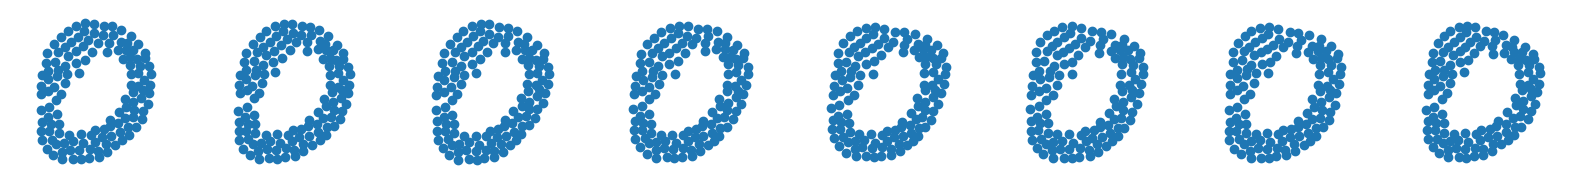

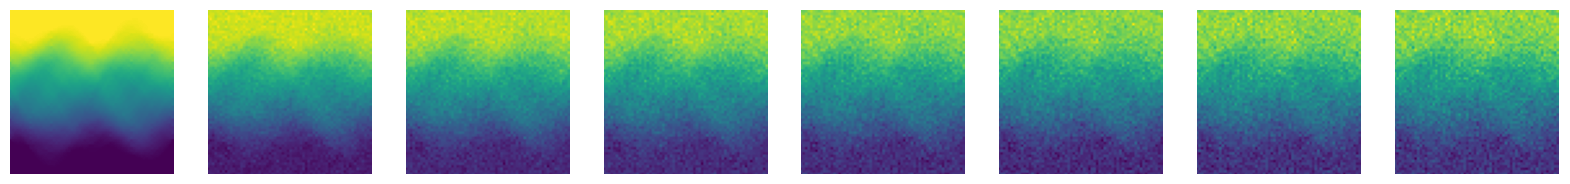

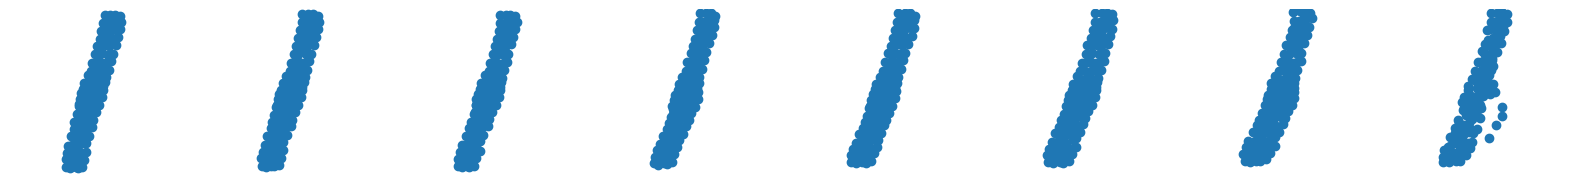

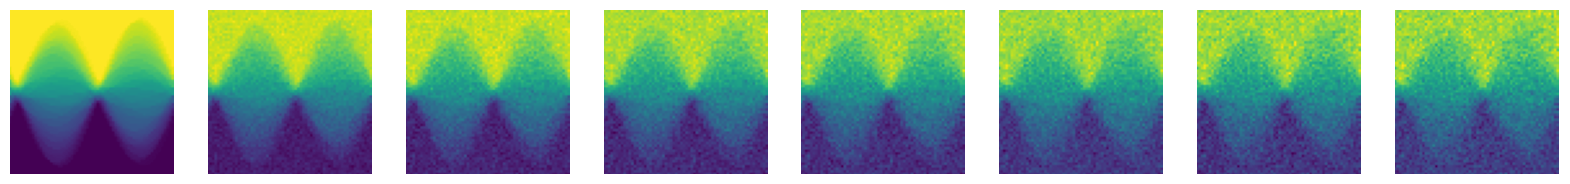

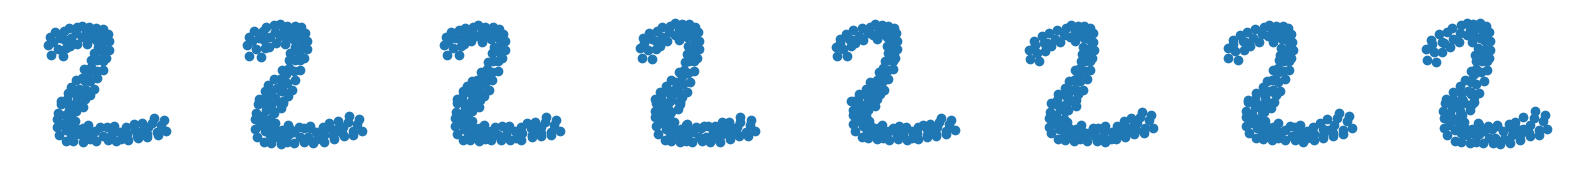

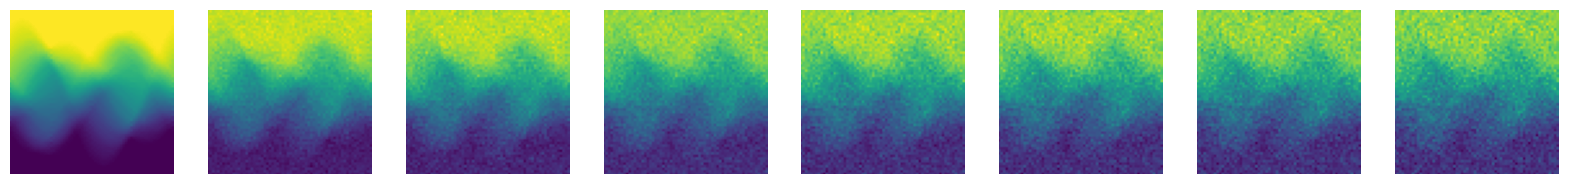

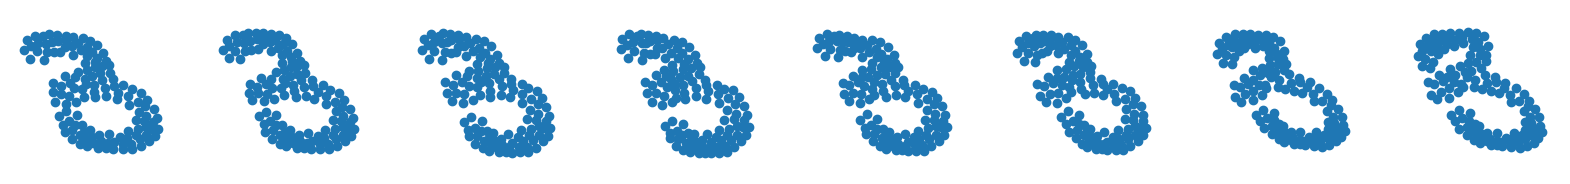

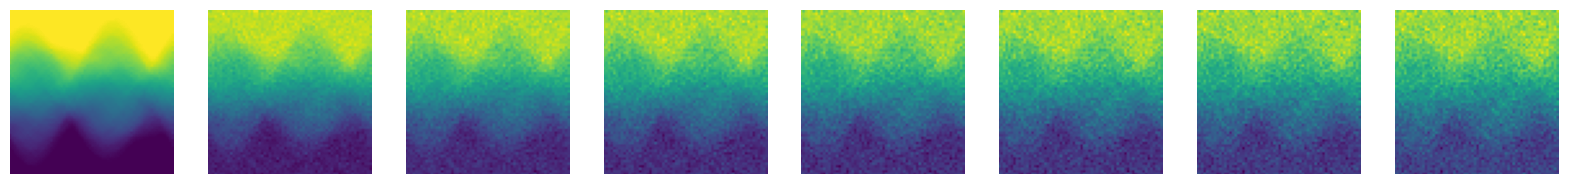

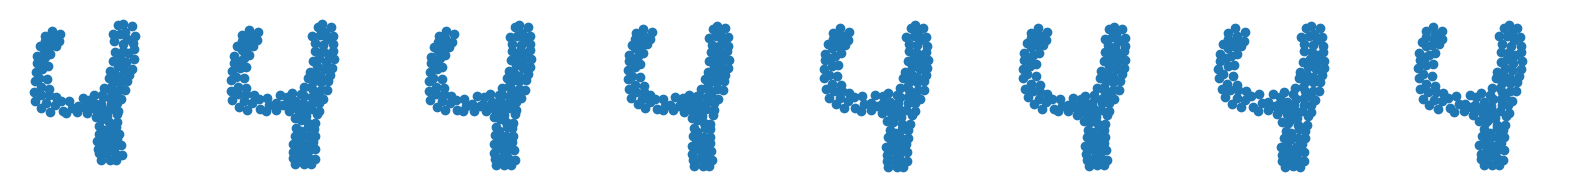

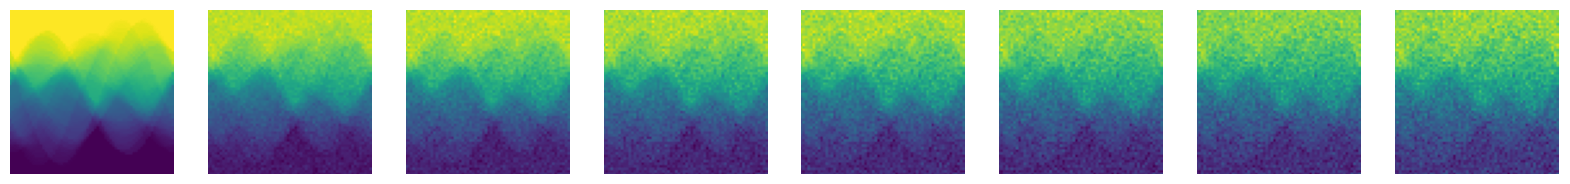

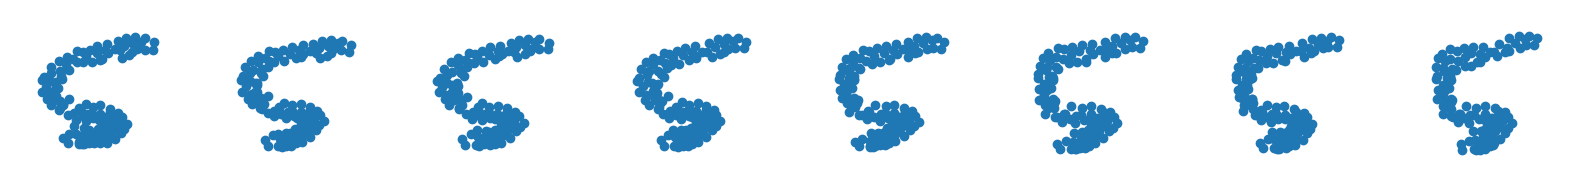

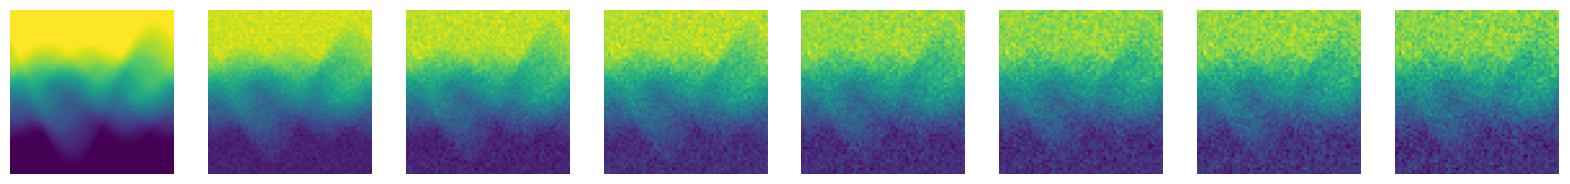

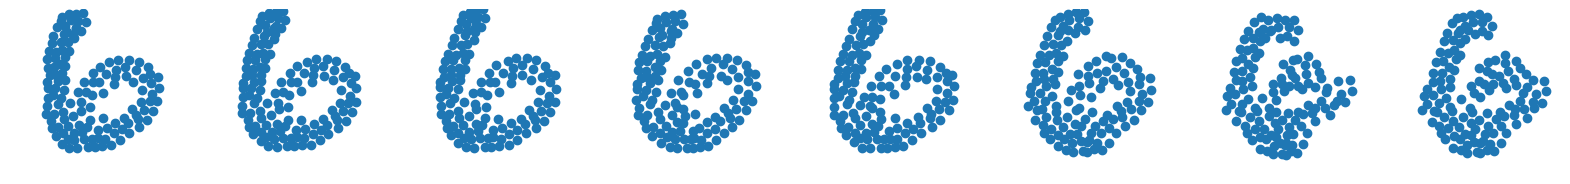

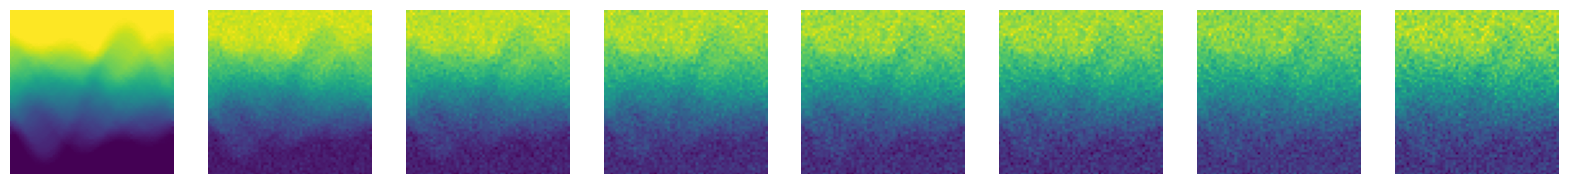

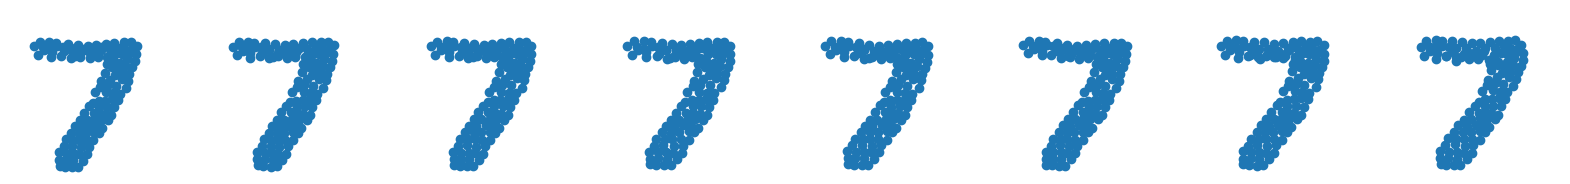

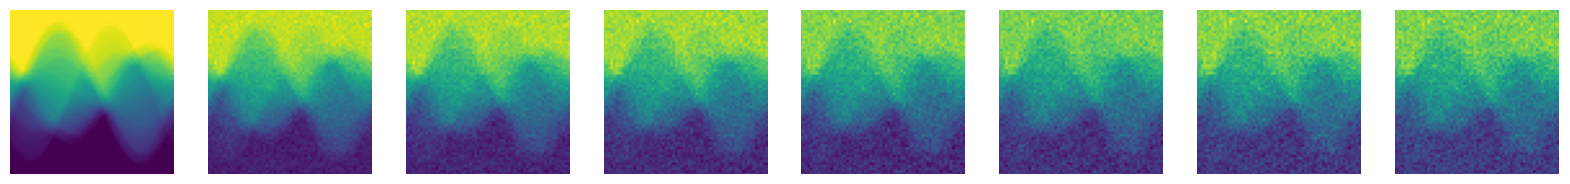

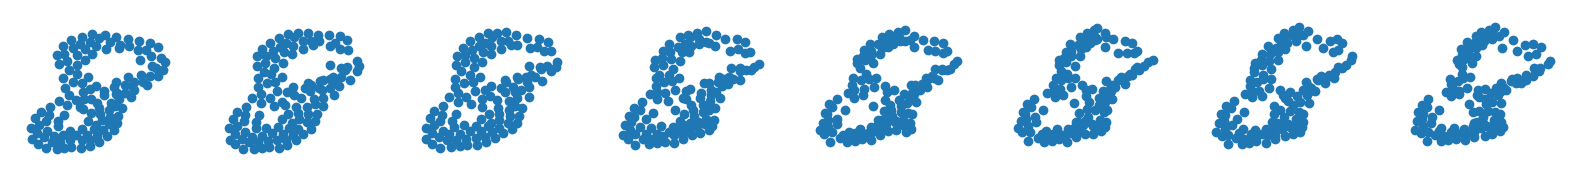

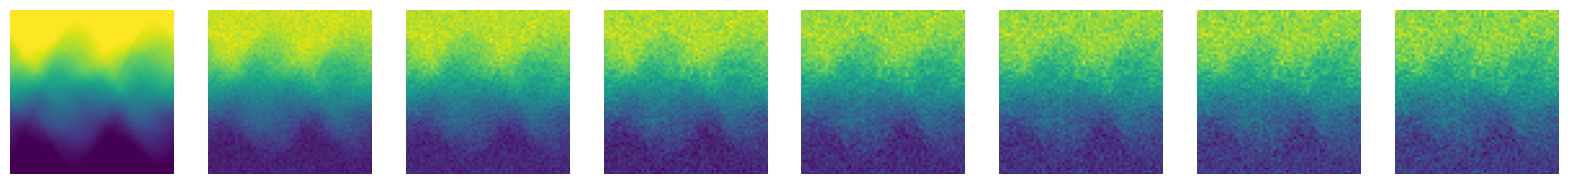

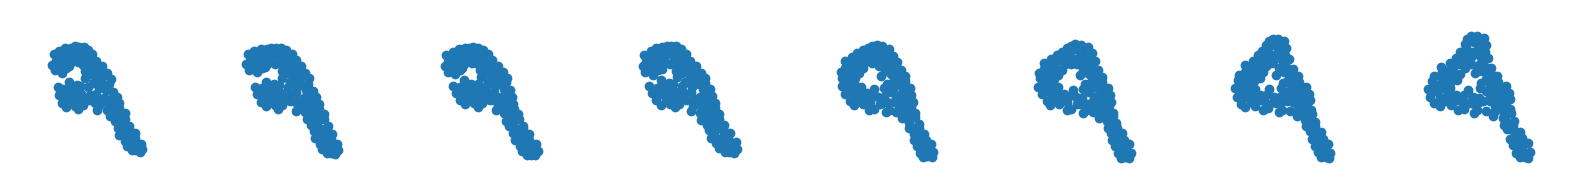

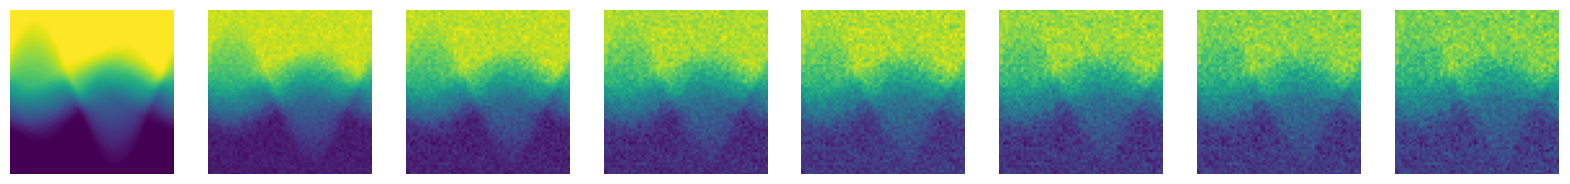

In [150]:
base_ects = layer(test_batch,test_batch.batch).unsqueeze(1)


# for base_ect in base_ects:

for ect in base_ects:

    ect_list = [ect]
    for _ in range(8):
        ect = ect + .03*torch.randn_like(ect)
        ect_list.append(ect)

    noise_batch = torch.vstack(ect_list)


    # Pass reconstruction through the point cloud decoder


    with torch.no_grad():
        recon_batch = ect_encoder_litmodel.model.forward(noise_batch)


    n_images = 8

    idx=0
    fig, axes = plt.subplots(
        nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20,5)
    )


    for recon_pts,ect,ax in zip(recon_batch[idx::],noise_batch,axes.T):
        # print(recon_pts_x.shape)
        recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
        recon_pts = rotate(recon_pts, degrees=-90)
        
        ax.scatter(recon_pts[:,0],recon_pts[:,1])
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.set_aspect(1)
        ax.axis("off")

    fig, axes = plt.subplots(
        nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20,5)
    )

    for recon_pts,ect,ax in zip(recon_batch[idx::],noise_batch,axes.T):
        # print(recon_pts_x.shape)
        recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
        recon_pts = rotate(recon_pts, degrees=-90)

        ax.imshow(ect.cpu().detach().squeeze().numpy())
        ax.set_xlim([0,64])
        ax.set_ylim([0,64])
        ax.axis("off")

# Add noise to the point cloud and reconstruct

In [121]:
from torch_geometric.data import Batch,Data
data_list = []
for idx in range(10):
    data_list.append(dm.test_ds[dm.test_ds.y==idx][0])

test_batch = Batch.from_data_list(data_list).to(DEVICE)



C:\Users\ernst\AppData\Local\Temp\ipykernel_2360\172590058.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(


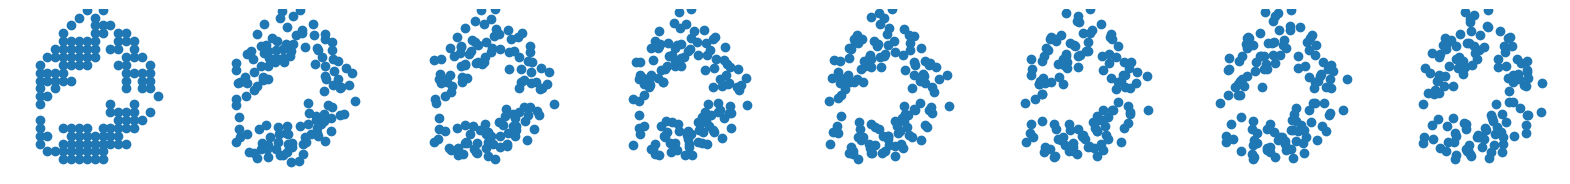

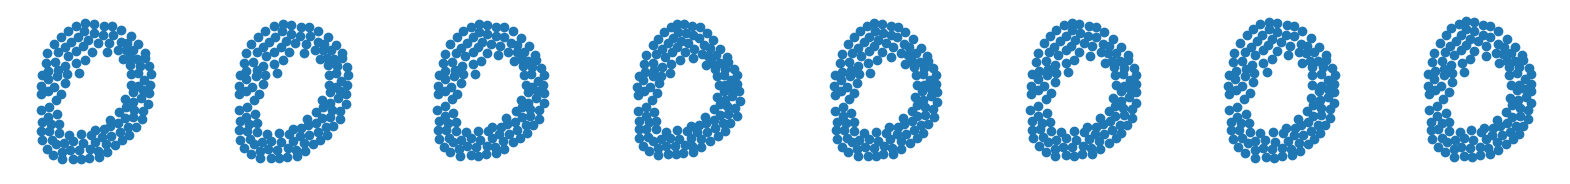

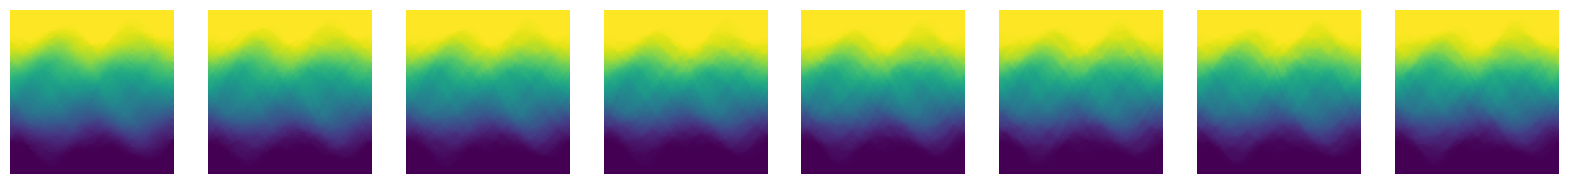

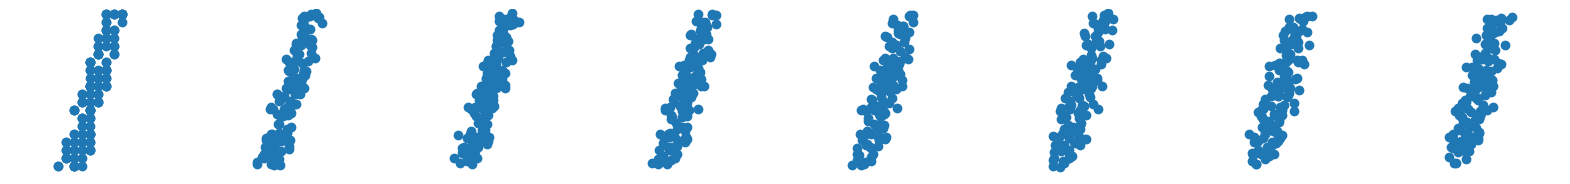

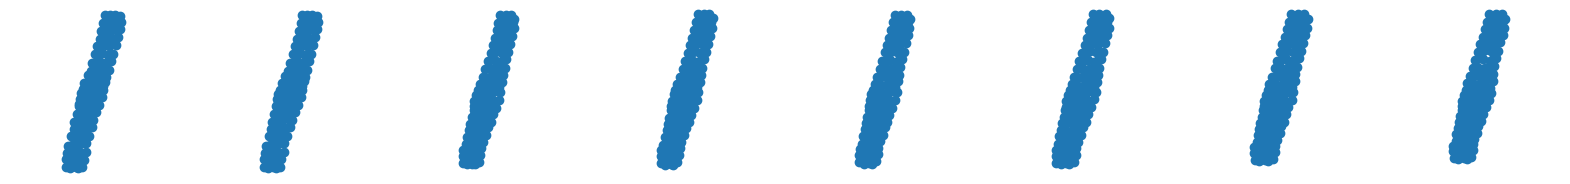

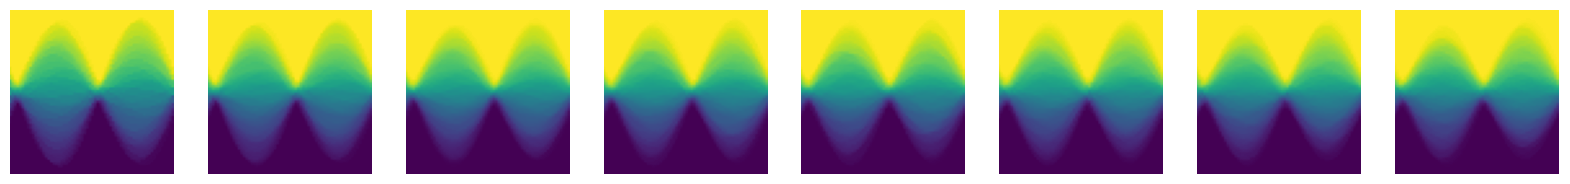

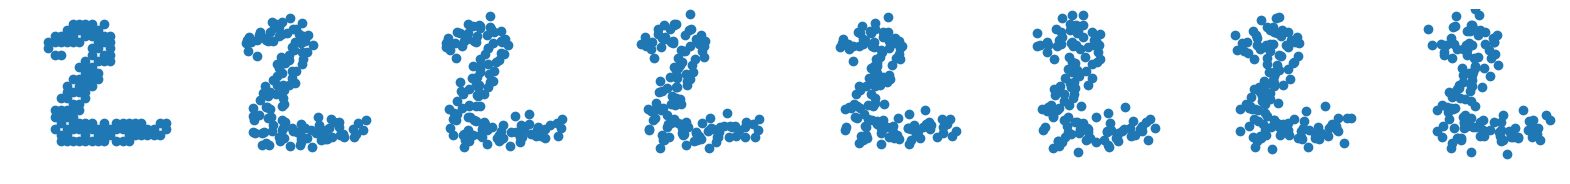

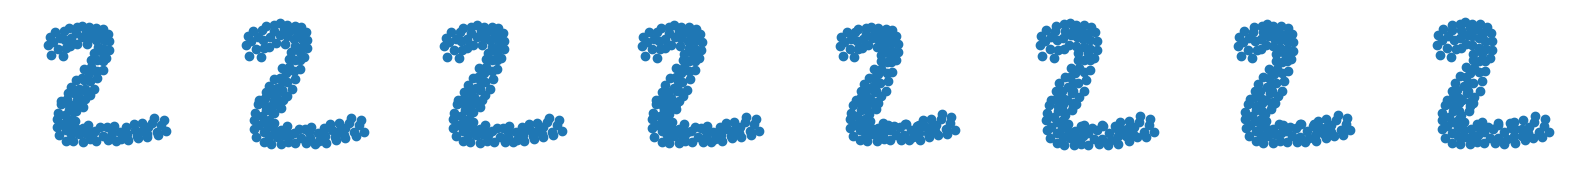

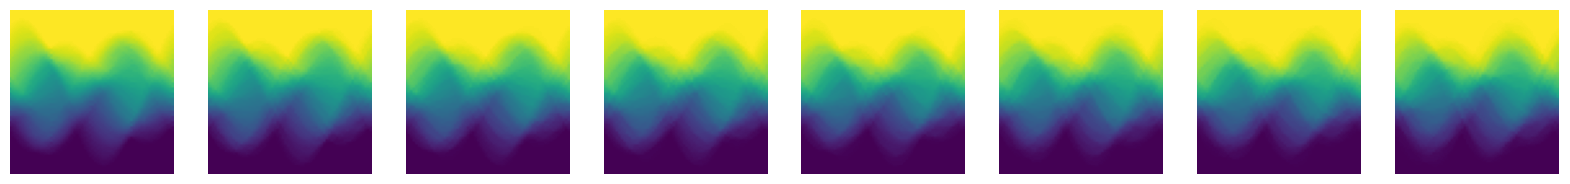

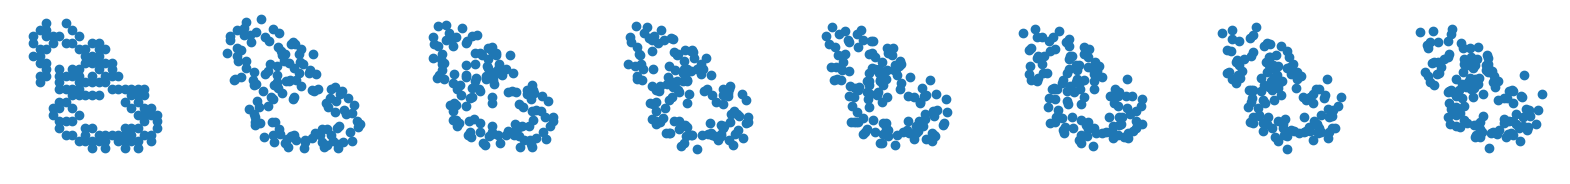

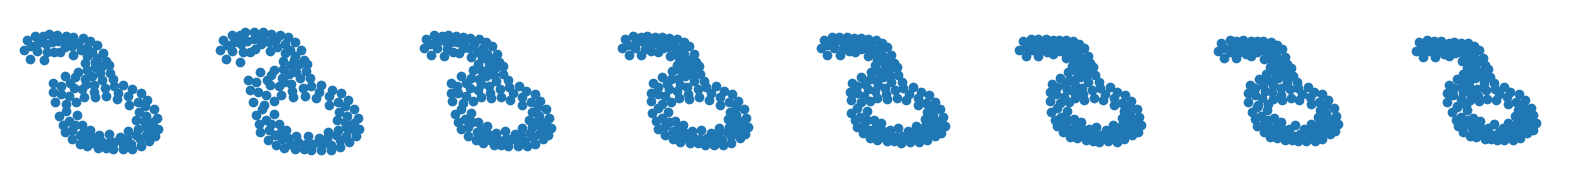

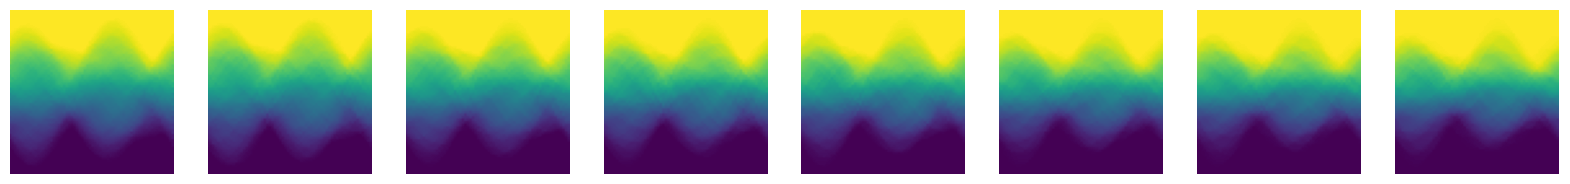

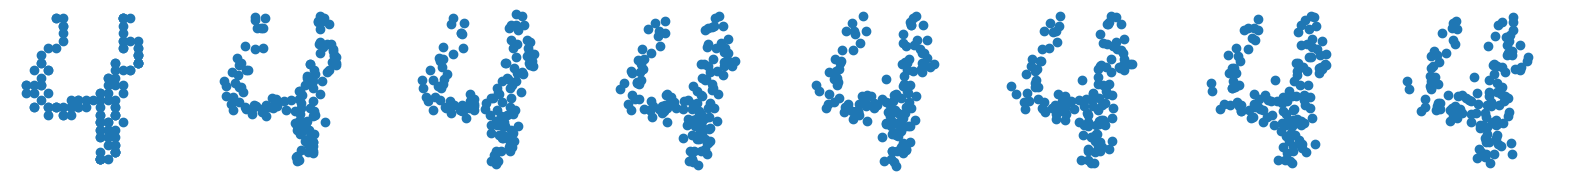

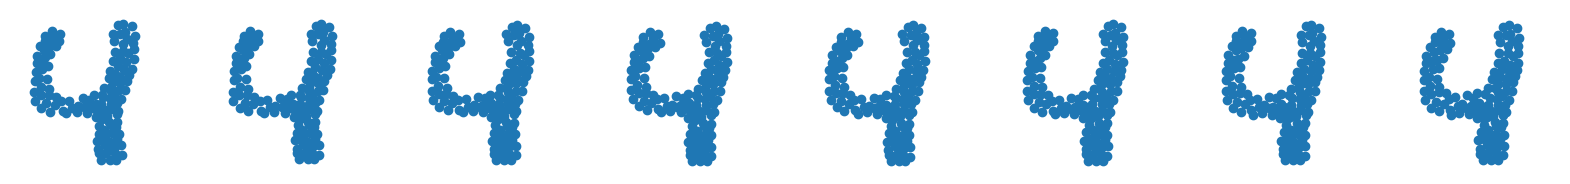

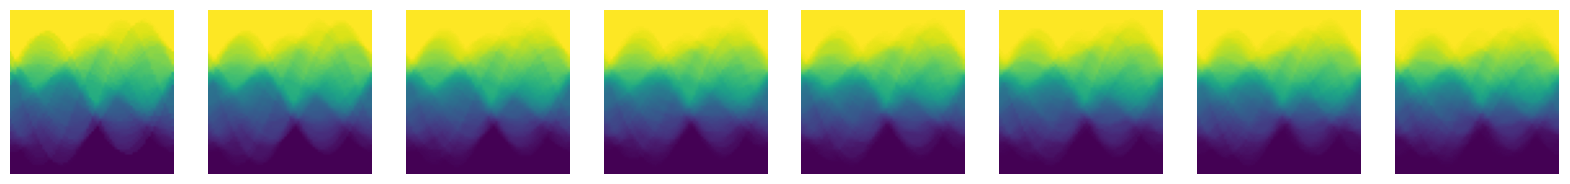

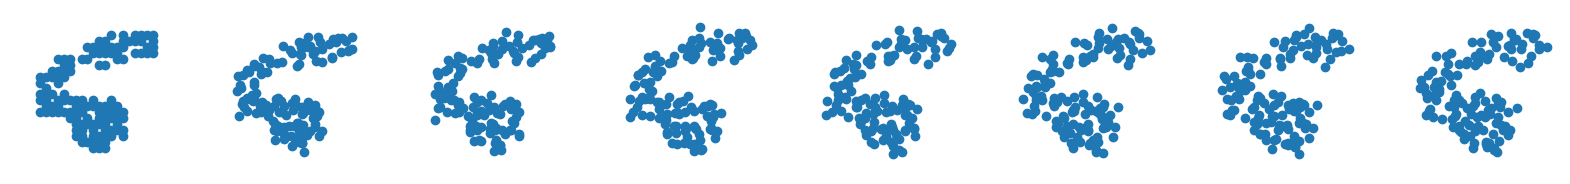

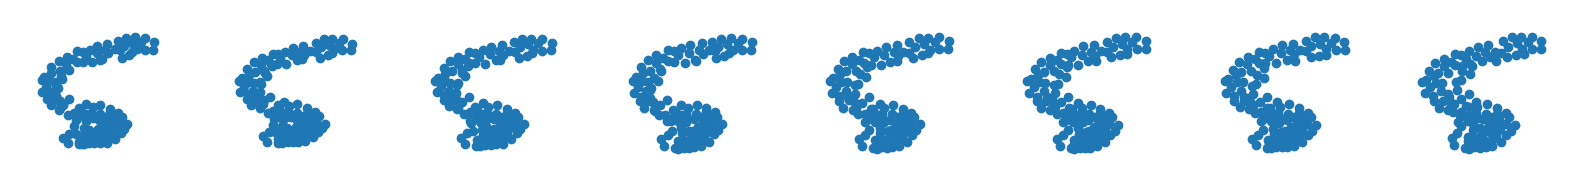

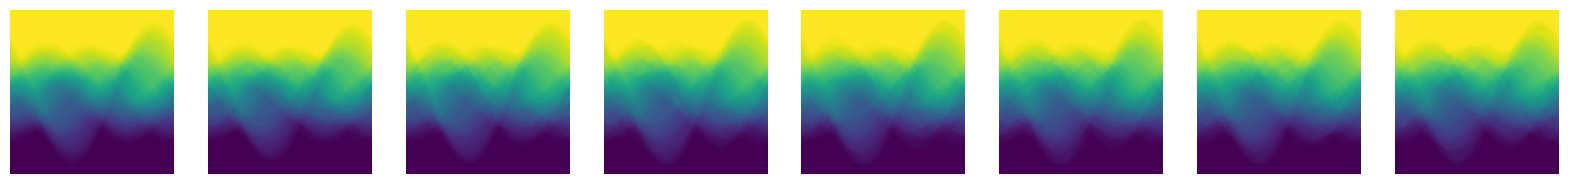

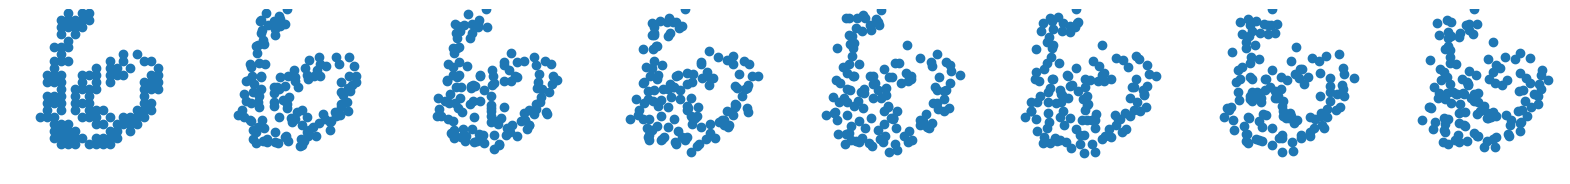

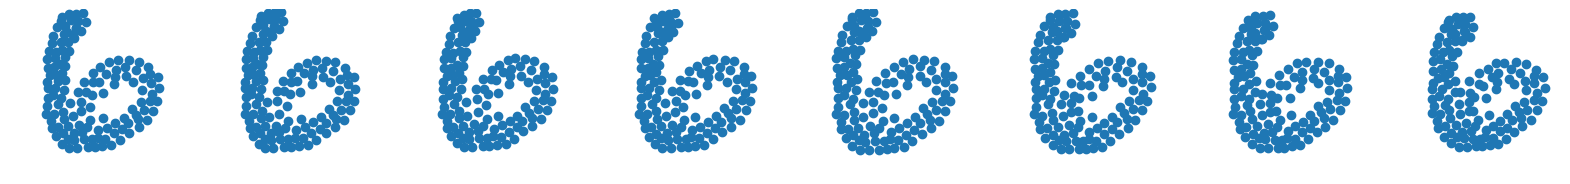

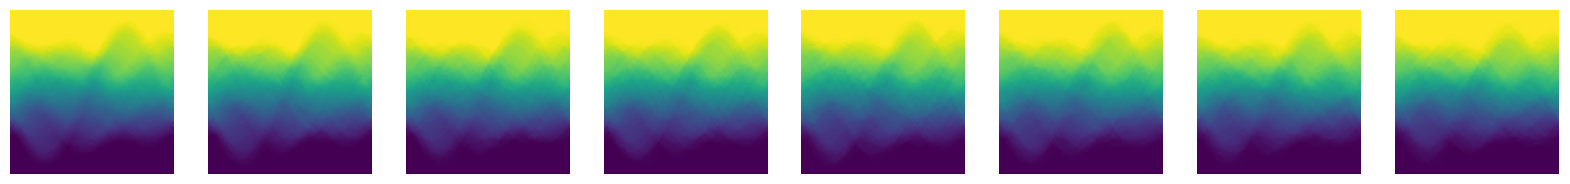

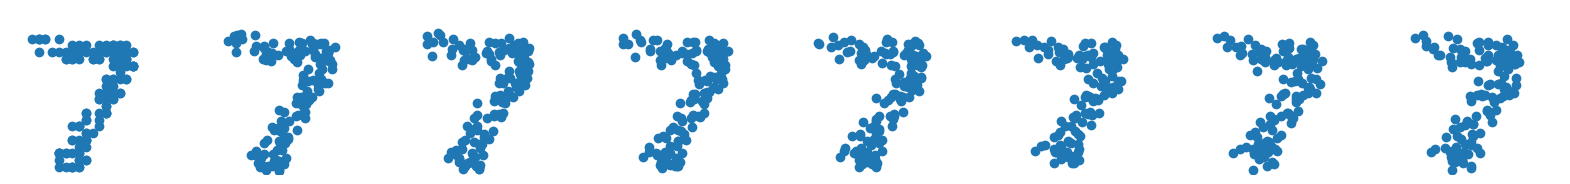

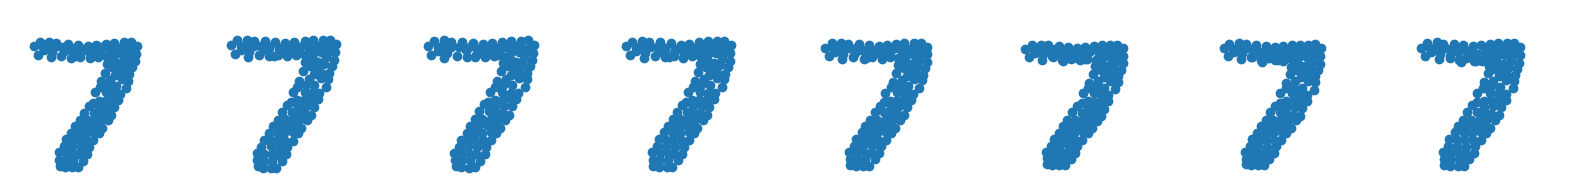

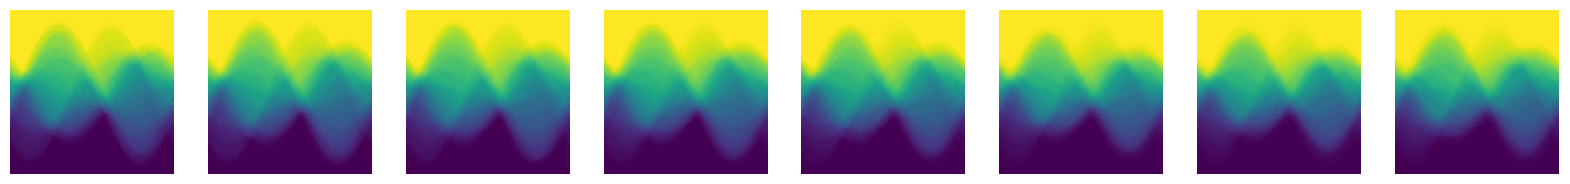

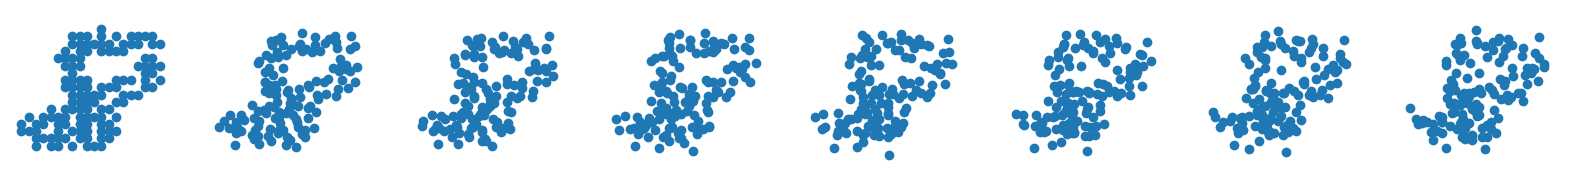

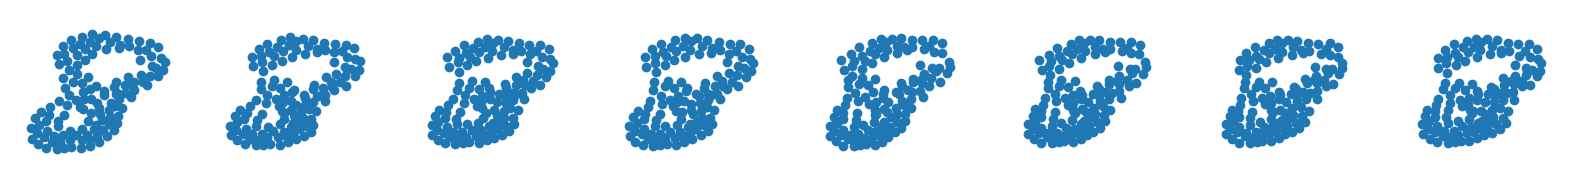

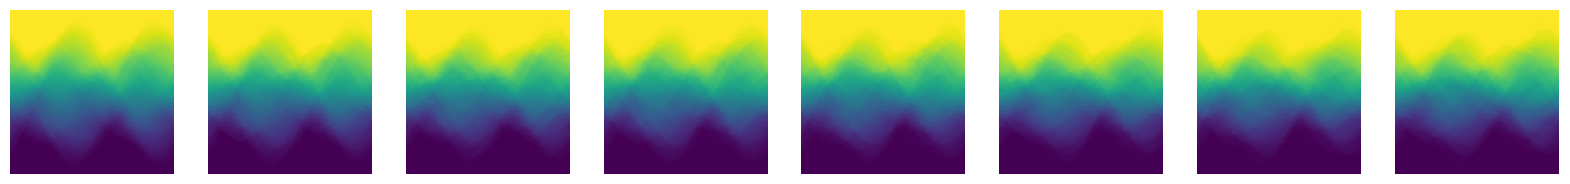

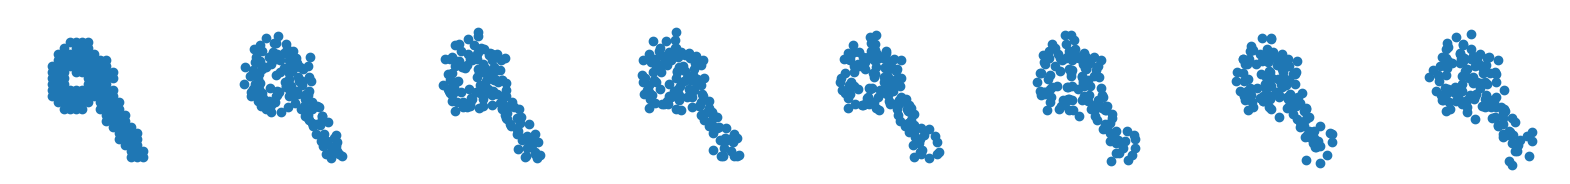

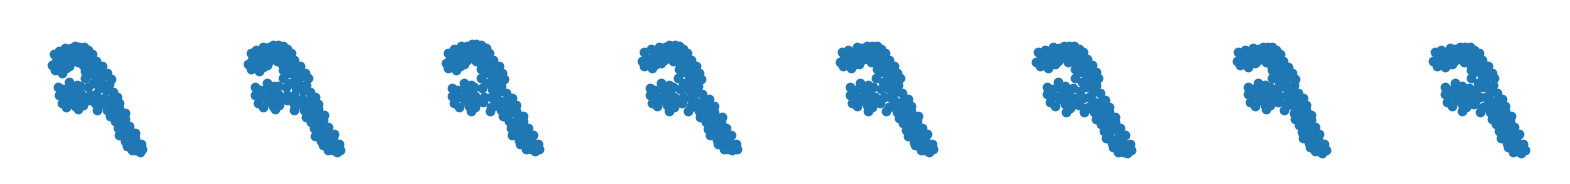

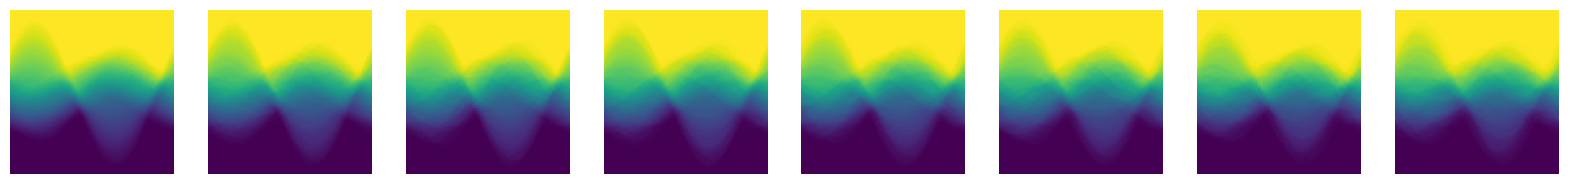

In [141]:
from datasets.transforms import CenterTransform

ctf = CenterTransform()

for class_idx in range(10):

    data = Data(x=test_batch[class_idx].x)
    pc_list = [data]
    for _ in range(7):
        data = ctf(Data(x = data.x + .03*torch.randn_like(data.x)))
        pc_list.append(data)

    noise_batch = Batch.from_data_list(pc_list)
    ect = layer(noise_batch,noise_batch.batch).unsqueeze(1)

    # Pass reconstruction through the point cloud decoder

    with torch.no_grad():
        recon_batch = ect_encoder_litmodel.model.forward(ect)


    n_images = 8

    fig, axes = plt.subplots(
        nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20,5)
    )


    for pts,ax in zip(noise_batch.x.view(-1,128,2),axes.T):
        
        pts = pts.view(-1,2).cpu().detach().squeeze().numpy()
        pts = rotate(pts, degrees=-90)
        
        ax.scatter(pts[:,0],pts[:,1])
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.set_aspect(1)
        ax.axis("off")

    fig, axes = plt.subplots(
        nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20,5)
    )

    for recon_pts,ax in zip(recon_batch,axes.T):
        # print(recon_pts_x.shape)
        recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
        recon_pts = rotate(recon_pts, degrees=-90)
        
        ax.scatter(recon_pts[:,0],recon_pts[:,1])
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.set_aspect(1)
        ax.axis("off")


    fig, axes = plt.subplots(
        nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20,5)
    )

    for ect_sample,ax in zip(ect,axes.T):

        ax.imshow(ect_sample.cpu().detach().squeeze().numpy())
        ax.set_xlim([0,64])
        ax.set_ylim([0,64])
        ax.axis("off")